**Hyperparameters and Root Directory**

In [0]:
# Use colab file.upload(), change this to the directory of your uploaded file
BASE_DIR = '/content' 

# Content layer where will pull our feature maps
CONTENT_LAYERS = ['block5_conv2'] 

# Style layer of interest
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# For Adam Optimizer later
LEARNING_RATE = 0.007
BETA_1 = 0.99
EPSILON = 1e-1

# Style and Content Weight
STYLE_WEIGHT = 1e-2
CONTENT_WEIGHT = 5e4

# Training Epochs
EPOCHS = 12
STEPS_PER_EPOCH = 100

TOTAL_VARIATION_WEIGHT = 40


**Import tensorflow & Configure Module**




In [0]:
import tensorflow as tf

In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [0]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

**Load Images for Style-transfer**

**1. Define functions to load and show the images**

In [0]:
# load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# Show image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

**2. Load Images and Visualize Inputs (Choose One to use)**


*   From Internet







In [0]:
# Load Images from Internet
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_img = load_img(content_path)
style_img = load_img(style_path)



*   From local Storage



In [38]:
# Load Images from local Storage
import os
from google.colab import files
print("Load Content Image")
content = files.upload()
for fn in content.keys():
  content_temp = fn
content_path = os.path.join(BASE_DIR, content_temp)
content_img = load_img(content_path)

print("Load Style Image")
style = files.upload()
for fn in style.keys():
  style_temp = fn
style_path = os.path.join(BASE_DIR, style_temp)
style_img = load_img(style_path)


Load Content Image


Saving royce corridor.jpg to royce corridor (1).jpg
Load Style Image


Saving Impressionism trees.jpg to Impressionism trees (1).jpg


**Show images**

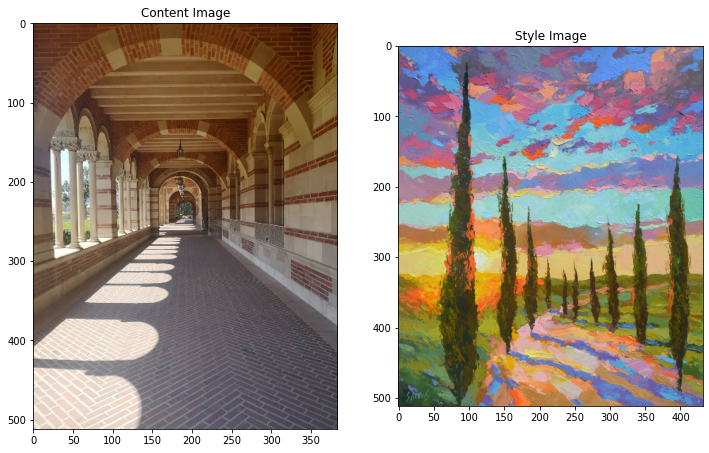

In [39]:
plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')

**Load VGG-19**

Run a model, Check if our images are correct

In [40]:
x = tf.keras.applications.vgg19.preprocess_input(content_img * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [41]:
# Check the probabilities of the predicted top 5 results to ensure you choose the correct content img and layer
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('library', 0.25409546),
 ('vault', 0.19489014),
 ('palace', 0.069389395),
 ('organ', 0.058066122),
 ('church', 0.0539145)]

**Display the layers of the model**
>P.s. In neural network, lower layers only display rudimentary features, like an edge or a point, so we'd better choose intermediate layer for doing style transfer



In [42]:
vgg = tf.keras.applications.VGG19(include_top = False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
num_content_layers = len(CONTENT_LAYERS)
num_style_layers = len(STYLE_LAYERS)

**Build the Model**

In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Create the model

In [0]:
style_extractor = vgg_layers(STYLE_LAYERS)
style_outputs = style_extractor(style_img*255)

**Calculate Style**

In [0]:
# Define the gram_matrix calculation
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

**Extract Style and Content**

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, STYLE_LAYERS, CONTENT_LAYERS):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(STYLE_LAYERS + CONTENT_LAYERS)
    self.STYLE_LAYERS = STYLE_LAYERS
    self.CONTENT_LAYERS = CONTENT_LAYERS
    self.num_style_layers = len(STYLE_LAYERS)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.CONTENT_LAYERS, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.STYLE_LAYERS, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

**This model returns the gram matrix (style) of the style_layers and content of the content_layers**

In [0]:
extractor = StyleContentModel(STYLE_LAYERS, CONTENT_LAYERS)
results = extractor(tf.constant(content_img))
style_results = results['style']

**Gradient Descent**

In [0]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

# Define a tf.Variable to contain the image to optimize. 
image = tf.Variable(content_img)

# Since this is a float img, we need to keep its pixel value between 0 and 1 (Convention)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Use Adam optimizer
opt = tf.optimizers.Adam(learning_rate= LEARNING_RATE, beta_1= BETA_1, epsilon= EPSILON)

# Use a weighted combination of the two losses to get the total loss
style_weight= STYLE_WEIGHT
content_weight= CONTENT_WEIGHT

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Use tf.GradientTape() to update the image
# Use total variation loss to denoise the image
total_variation_weight= TOTAL_VARIATION_WEIGHT
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


**Optimization**

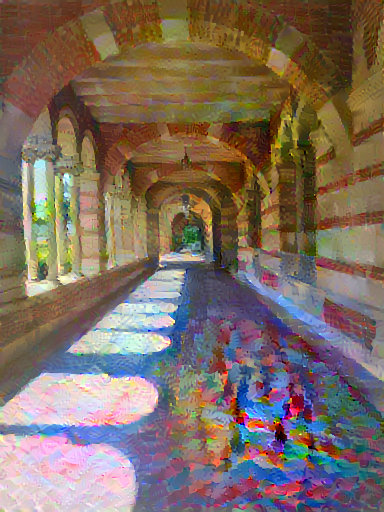

Train step: 1200
Total time: 86.0


In [50]:
import time
start = time.time()

epochs = EPOCHS
steps_per_epoch = STEPS_PER_EPOCH

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))